In [3]:
import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

import gc
from itertools import product
import warnings
warnings.filterwarnings("ignore")
from math import ceil
import copy
import os
from IPython.display import clear_output

import nltk
from sklearn.feature_extraction import text
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD, NMF
import lightgbm as lgb
import xgboost as xgb

from sklearn.linear_model import LinearRegression, Ridge, Lasso, Lars, ElasticNet

from sklearn.externals import joblib

In [4]:
item_categories = pd.read_csv('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/item_categories.csv')
items = pd.read_csv('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/items.csv')
train = pd.read_csv('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/sales_train.csv')
sample = pd.read_csv('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/sample_submission.csv')
shops = pd.read_csv('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/shops.csv')
test = pd.read_csv('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/test.csv')

In [5]:
train['sales'] = train['item_cnt_day']*train['item_price']
print(train.shape)
print(train.nunique())
train.head()

(2935849, 7)
date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
sales             24775
dtype: int64


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales
0,02.01.2013,0,59,22154,999.00,1.00,999.00
1,03.01.2013,0,25,2552,899.00,1.00,899.00
2,05.01.2013,0,25,2552,899.00,-1.00,-899.00
3,06.01.2013,0,25,2554,"1,709.05",1.00,"1,709.05"
4,15.01.2013,0,25,2555,"1,099.00",1.00,"1,099.00"


In [6]:
test1 = copy.copy(test)
test1['shop_id'] = test1['shop_id'].map(str)
test1['item_id'] = test1['item_id'].map(str)
test1['key'] = test1[['shop_id', 'item_id']].apply(lambda x: '-'.join(x), axis=1)
print(test1['key'].nunique() == len(test1))
del test1; gc.collect();

True


In [7]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [10]:
items1 = pd.read_csv('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/items.csv')
item_categories1 = pd.read_csv('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/item_categories.csv')
shops1 = pd.read_csv('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/shops.csv')

In [11]:
nb_features=25
tfidf = text.TfidfVectorizer(max_features=nb_features)
items1['item_name_len'] = items1['item_name'].map(len)  # Name lenth
items1['item_name_wc'] = items1['item_name'].map(lambda x: len(str(x).split(' ')))  # Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(items1['item_name']).toarray())
cols = txtFeatures.columns
for i in range(nb_features):
    items1['item_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
items1.head()

,item_name,item_id,item_category_id,item_name_len,item_name_wc,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,...,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,41,14,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,68,9,0.00,0.00,0.00,0.00,0.00,...,0.00,0.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.48
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,45,26,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,47,26,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,***КОРОБКА (СТЕКЛО) D,4,40,43,25,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [12]:
tfidf = text.TfidfVectorizer(max_features = nb_features)
shops1['shop_name_len'] = shops1['shop_name'].map(len)  # Name lenth
shops1['shop_name_wc'] = shops1['shop_name'].map(lambda x: len(str(x).split(' ')))  # Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(shops1['shop_name']).toarray())
cols = txtFeatures.columns
for i in range(nb_features):
    shops1['shop_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
shops1.head()

,shop_name,shop_id,shop_name_len,shop_name_wc,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,...,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,"!Якутск Орджоникидзе, 56 фран",0,29,4,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1,"!Якутск ТЦ ""Центральный"" фран",1,29,4,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.32,0.00,0.69,0.65
2,"Адыгея ТЦ ""Мега""",2,16,3,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00
3,"Балашиха ТРК ""Октябрь-Киномир""",3,30,3,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
4,"Волжский ТЦ ""Волга Молл""",4,24,4,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.42,0.00,0.00,0.00


In [13]:
cols = ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(train.duplicated(subset=cols).value_counts())
train.drop_duplicates(subset=cols, inplace=True)

False    2935825
True          24
dtype: int64


In [14]:
train1 = []
cols = ['date_block_num','shop_id','item_id']
for block_num in range(34):
    temp = train[train.date_block_num==block_num]
    train1.append(np.array(list(product([block_num], temp['shop_id'].unique(), temp['item_id'].unique()))))
    
train1 = pd.DataFrame(np.vstack(train1), columns=cols)
train1['date_block_num'] = train1['date_block_num'].astype(np.int8)
train1['shop_id'] = train1['shop_id'].astype(np.int8)
train1['item_id'] = train1['item_id'].astype(np.int16)
train1.sort_values(cols,inplace=True);
train1.head()

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32


In [16]:
temp = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
temp.columns = ['item_cnt_month']
temp.reset_index(inplace=True)

train1 = pd.merge(train1, temp, on=cols, how='left')
train1['item_cnt_month'] = (train1['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))
print(train1.shape)
train1.head()

(10913850, 4)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.00
1,0,0,27,0.00
2,0,0,28,0.00
3,0,0,29,0.00
4,0,0,32,6.00


In [17]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

train2 = pd.concat([train1, test], ignore_index=True, sort=False, keys=cols)
train2.fillna(0, inplace=True)
print(train2.shape)
train2.tail()

(11128050, 5)


,date_block_num,shop_id,item_id,item_cnt_month,ID
11128045,34,45,18454,0.00,"214,195.00"
11128046,34,45,16188,0.00,"214,196.00"
11128047,34,45,15757,0.00,"214,197.00"
11128048,34,45,19648,0.00,"214,198.00"
11128049,34,45,969,0.00,"214,199.00"


In [18]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [19]:
train3 = pd.merge(train2, shops, on=['shop_id'], how='left')
train3 = pd.merge(train3, items, on=['item_id'], how='left')
train3 = pd.merge(train3, item_categories, on=['item_category_id'], how='left')

In [20]:
########## 1. Create 'date_avg_item_cnt'
temp = train3.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_avg_item_cnt']          ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num'], how='left')
train3 = lag_feature(train3, [1], 'date_avg_item_cnt')
train3.drop(['date_avg_item_cnt'], axis=1, inplace=True)

########## 2. Create 'date_item_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_item_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num','item_id'], how='left')
train3 = lag_feature(train3, [1, 2, 3, 6, 12], 'date_item_avg_item_cnt')
train3.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

########## 3. Create 'date_shop_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num','shop_id'], how='left')
train3 = lag_feature(train3, [1, 2, 3, 6, 12], 'date_shop_avg_item_cnt')
train3.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

########## 4. Create 'date_cat_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_cat_avg_item_cnt']      ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num','item_category_id'], how='left')
train3 = lag_feature(train3, [1], 'date_cat_avg_item_cnt')
train3.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

########## 5. Create 'date_shop_cat_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_cat_avg_item_cnt']    ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
train3 = lag_feature(train3, [1], 'date_shop_cat_avg_item_cnt')
train3.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

########## 6. Create 'date_shop_type_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_type_avg_item_cnt']    ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'shop_id', 'type_code'], how='left')
train3 = lag_feature(train3, [1], 'date_shop_type_avg_item_cnt')
train3.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

########## 7. Create 'date_type_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_type_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'type_code'], how='left')
train3 = lag_feature(train3, [1], 'date_type_avg_item_cnt')
train3.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

########## 8. Create 'date_city_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_city_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'city_code'], how='left')
train3 = lag_feature(train3, [1], 'date_city_avg_item_cnt')
train3.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

########## 9. Create 'date_shop_subtype_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_subtype_avg_item_cnt']   ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
train3 = lag_feature(train3, [1], 'date_shop_subtype_avg_item_cnt')
train3.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

########## 10. Create 'date_item_city_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_item_city_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'item_id', 'city_code'], how='left')
train3 = lag_feature(train3, [1], 'date_item_city_avg_item_cnt')
train3.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

########## 11. Create 'date_subtype_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_subtype_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'subtype_code'], how='left')
train3 = lag_feature(train3, [1], 'date_subtype_avg_item_cnt')
train3.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
train3.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,...,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,0,19,0.00,0.00,29,40,11,4,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0,0,27,0.00,0.00,29,19,5,10,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0,0,28,0.00,0.00,29,30,8,55,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0,0,29,0.00,0.00,29,23,5,16,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0,0,32,6.00,0.00,29,40,11,4,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [21]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [22]:
# Trend features for prices
temp = train.groupby(['item_id']).agg({'item_price': ['mean']})
temp.columns = ['item_avg_item_price']
temp.reset_index(inplace=True)
train4 = pd.merge(train3, temp, on=['item_id'], how='left')

temp = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
temp.columns = ['date_item_avg_item_price']
temp.reset_index(inplace=True)
train4 = pd.merge(train4, temp, on=['date_block_num','item_id'], how='left')

lags = [1,2,3,4,5,6]
train4 = lag_feature(train4, lags, 'date_item_avg_item_price')

for i in lags:
    train4['delta_price_lag_'+str(i)] = \
    (train4['date_item_avg_item_price_lag_'+str(i)] - train4['item_avg_item_price']) / train4['item_avg_item_price']
    
train4['delta_price_lag'] = train4.apply(select_trend, axis=1)
train4['delta_price_lag'].fillna(0, inplace=True)

dropped_cols = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    dropped_cols += ['date_item_avg_item_price_lag_'+str(i)]
    dropped_cols += ['delta_price_lag_'+str(i)]

train4.drop(dropped_cols, axis=1, inplace=True)

In [24]:
# Trend features for revenue
temp = train.groupby(['date_block_num','shop_id']).agg({'sales': ['sum']})
temp.columns = ['date_shop_revenue']
temp.reset_index(inplace=True)
train4 = pd.merge(train4, temp, on=['date_block_num','shop_id'], how='left')

temp = train4.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
temp.columns = ['shop_avg_revenue']
temp.reset_index(inplace=True)
train4 = pd.merge(train4, temp, on=['shop_id'], how='left')

train4['delta_revenue'] = (train4['date_shop_revenue'] - train4['shop_avg_revenue']) / train4['shop_avg_revenue']
train4 = lag_feature(train4, [1], 'delta_revenue')
train4.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [25]:
train4['delta_revenue_lag_1'] = train4['delta_revenue_lag_1'].fillna(0.0)

In [26]:
print(train4.shape)
train4.head()

(11128050, 30)


,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,...,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,0,19,0.00,0.00,29,40,11,4,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00
1,0,0,27,0.00,0.00,29,19,5,10,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00
2,0,0,28,0.00,0.00,29,30,8,55,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00
3,0,0,29,0.00,0.00,29,23,5,16,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00
4,0,0,32,6.00,0.00,29,40,11,4,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00


In [27]:
df = train4[train4['date_block_num'] > 11]
print(df.shape)

for col in df.columns:
    if ('_lag_' in col) & (df[col].isnull().any()):
        if ('item_cnt' in col):
            df[col].fillna(0, inplace=True)

(6639294, 30)


In [28]:
df = pd.merge(df, items1, how='left', on='item_id')
df = pd.merge(df, shops1, how='left', on='shop_id')
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id_x,type_code,subtype_code,date_avg_item_cnt_lag_1,...,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,12,2,27,0.00,0.00,0,19,5,10,0.41,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00
1,12,2,30,0.00,0.00,0,40,11,4,0.41,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00
2,12,2,31,0.00,0.00,0,37,11,1,0.41,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00
3,12,2,32,1.00,0.00,0,40,11,4,0.41,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00
4,12,2,33,1.00,0.00,0,37,11,1,0.41,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00


In [29]:
df.columns.values

array(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'city_code', 'item_category_id_x', 'type_code', 'subtype_code',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_type_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_revenue_lag_1', 'item_name', 'item_category_id_y',
       'item_name_len', 'item_name_wc', 'item_name_tfidf_0',


In [30]:
df.drop(['item_name', 'item_name_len', 'item_name_wc', 'item_category_id_y',
         'shop_name', 'shop_name_len', 'shop_name_wc'], axis=1, inplace=True)
print(df.shape)

(6639294, 80)


In [31]:
cat_features = ['shop_id', 'item_id', 'city_code', 'item_category_id_x', 'type_code', 'subtype_code']

In [32]:
del train1, train2, train3, train4, temp
gc.collect()

227

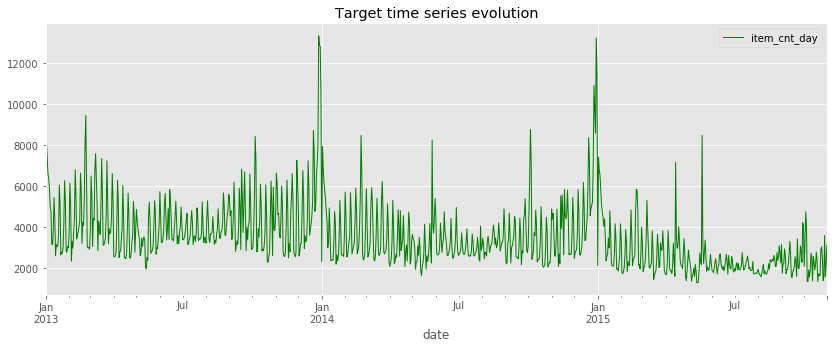

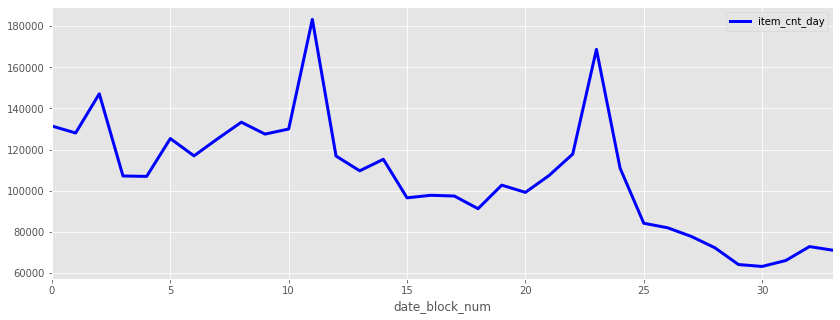

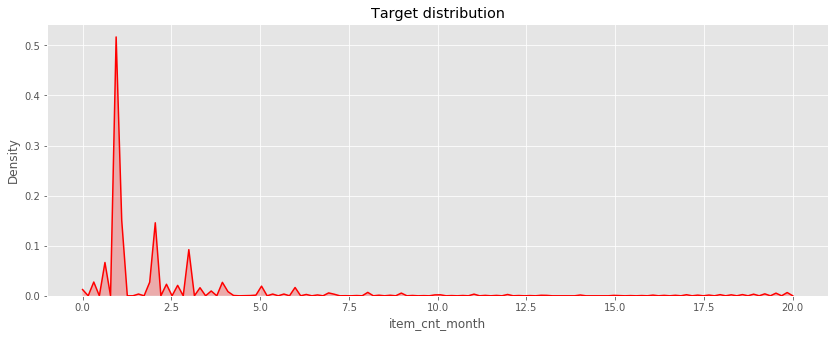

In [33]:
train['date'] = pd.to_datetime(train['date'], format="%d.%m.%Y")
train.groupby('date').agg({'item_cnt_day': 'sum'}).plot(figsize=(14,5), title='Target time series evolution', lw=1.0, color='green')
train.groupby('date_block_num').agg({'item_cnt_day': 'sum'}).plot(figsize=(14,5), lw=3.0, color='blue')
plt.show()

fig, ax = plt.subplots(figsize=(14,5))
ax = sns.kdeplot(df['item_cnt_month'].values, shade=True, color="red", ax=ax)
ax.set_xlabel('item_cnt_month')
ax.set_ylabel('Density')
ax.set_title('Target distribution')
plt.show()

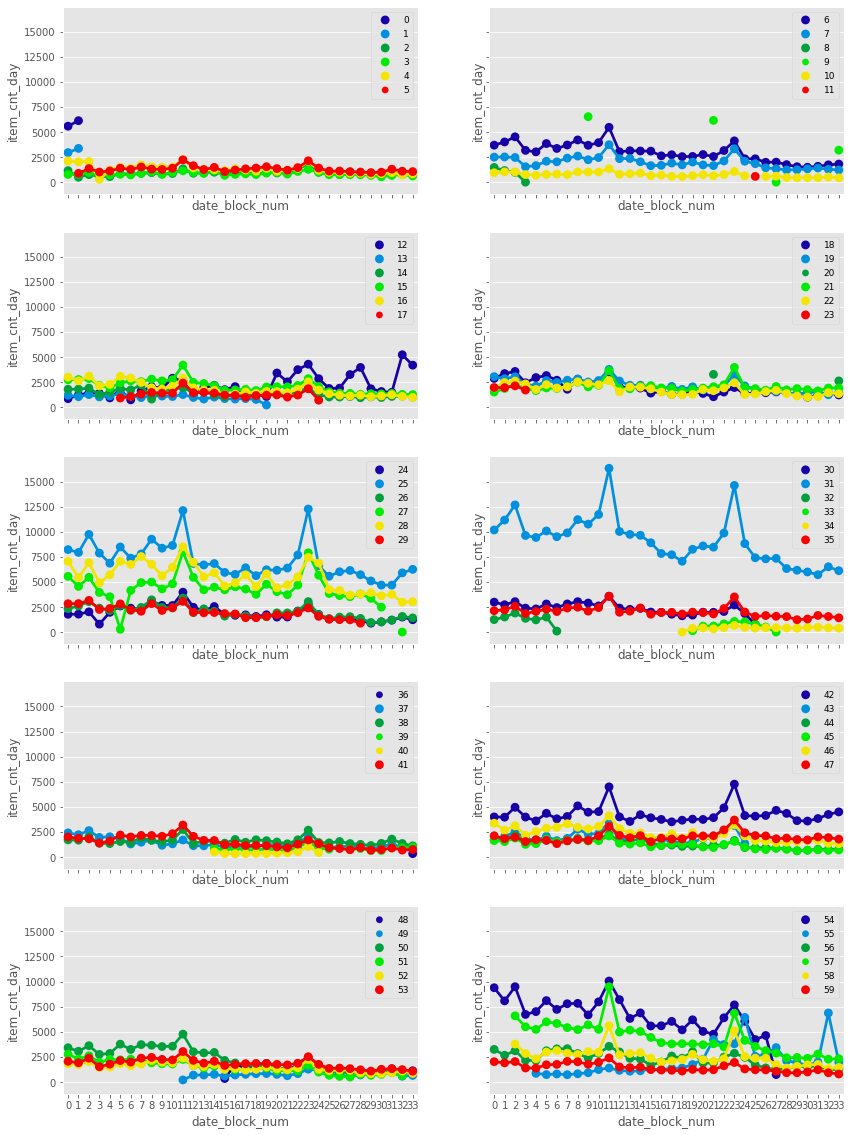

In [34]:
temp = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(14,20))
num_graph = 10
id_per_graph = ceil(temp.shop_id.max() / num_graph)
#fig.suptitle('Time series evolution of sales (per shop)')
x = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', palette='nipy_spectral',
                      data=temp[np.logical_and(x*id_per_graph <= temp['shop_id'],
                                               temp['shop_id'] < (x+1)*id_per_graph)],
                      ax=axes[i][j], grid=True, lw=1.0)
        axes[i,j].legend(loc='upper right')
        plt.setp(axes[i,j].get_legend().get_texts(), fontsize='9')
        plt.setp(axes[i,j].get_legend().get_title(), fontsize='10')
        x += 1

sns.reset_orig()

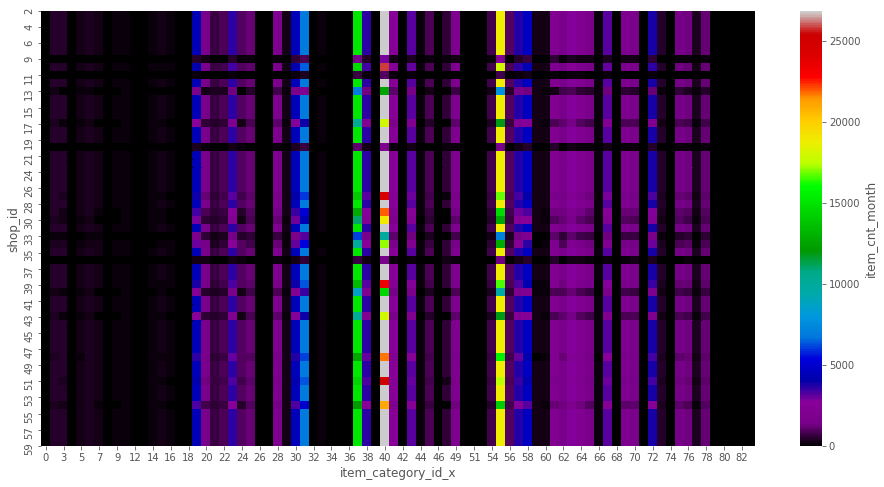

In [35]:
stores_hm = df.pivot_table(index='shop_id', columns='item_category_id_x', values='item_cnt_month', aggfunc='count', fill_value=0)
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(stores_hm, cmap='nipy_spectral', ax=ax, cbar=True, cbar_kws={'label': 'item_cnt_month'});

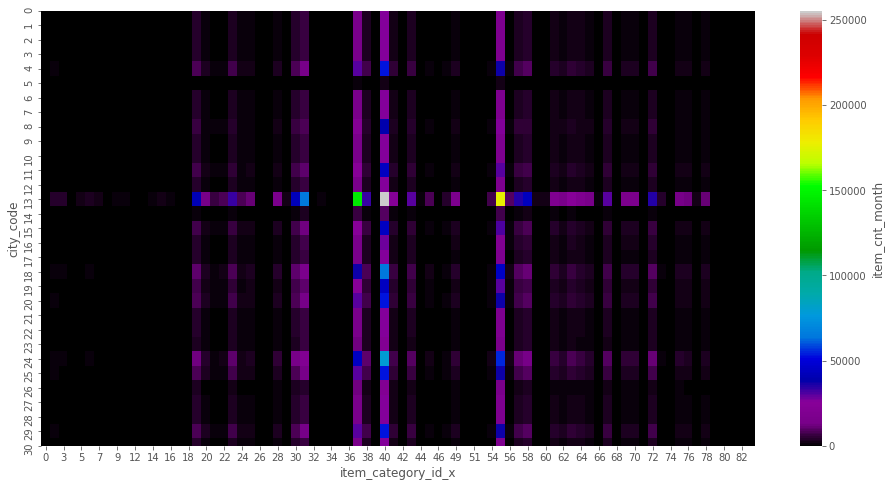

In [36]:
stores_hm = df.pivot_table(index='city_code', columns='item_category_id_x', values='item_cnt_month', aggfunc='count', fill_value=0)
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(stores_hm, cmap='nipy_spectral', ax=ax, cbar=True, cbar_kws={'label': 'item_cnt_month'});

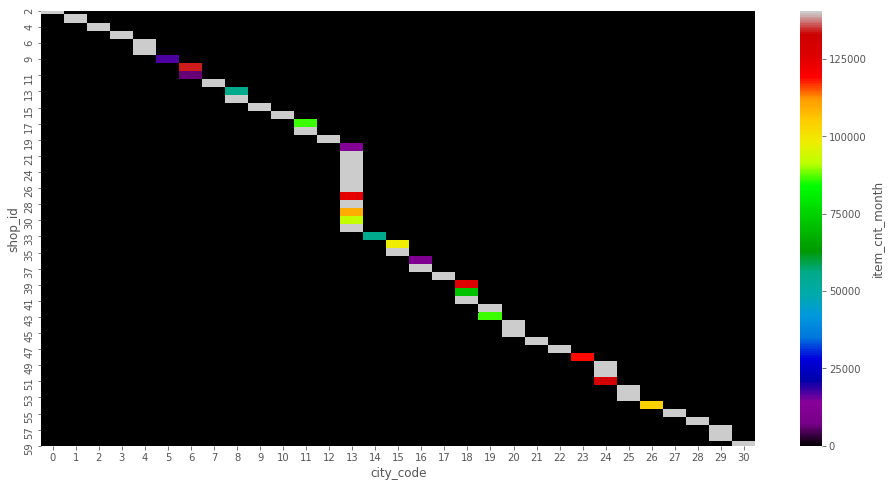

In [37]:
stores_hm = df.pivot_table(index='shop_id', columns='city_code', values='item_cnt_month', aggfunc='count', fill_value=0)
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(stores_hm, cmap='nipy_spectral', ax=ax, cbar=True, cbar_kws={'label': 'item_cnt_month'});

In [ ]:
df1 = copy.copy(df)

In [ ]:
df1.reset_index(inplace=True)

In [ ]:
cv = KFold(n_splits=5, shuffle=False)
new_features = []
check = False

In [ ]:
for train_idx, valid_idx in cv.split(df1):
    
    # Train/validation split
    X_train, X_valid = df1.iloc[train_idx,:], df1.iloc[valid_idx,:]
    
    # Mean encoding
    for col in cat_features:
        means = X_valid[col].map(X_train.groupby(col).item_cnt_month.mean())
        col_new = col+'_target_enc'
        X_valid[col_new] = means
        
        # Results
        df1.loc[valid_idx, col_new] = X_valid
        
        # Store new columns
        if check==False:
            new_features.append(col_new)
    
    check = True

In [ ]:
print(new_features)

In [ ]:
# Dealing with missing values
new_features = ['shop_id_target_enc', 'item_id_target_enc', 'city_code_target_enc',
                'item_category_id_x_target_enc', 'type_code_target_enc', 'subtype_code_target_enc']
prior = np.mean(df1['item_cnt_month'].values)
df1[new_features] = df1[new_features].fillna(prior)
df1.head()

In [ ]:
df1.drop(cat_features, axis=1, inplace=True)
df1.drop('index', axis=1, inplace=True)
cat_features = new_features

In [ ]:
tfidf_features = ['item_name_tfidf_0', 'item_name_tfidf_1', 'item_name_tfidf_2',
                  'item_name_tfidf_3', 'item_name_tfidf_4', 'item_name_tfidf_5',
                  'item_name_tfidf_6', 'item_name_tfidf_7', 'item_name_tfidf_8',
                  'item_name_tfidf_9', 'item_name_tfidf_10', 'item_name_tfidf_11',
                  'item_name_tfidf_12', 'item_name_tfidf_13', 'item_name_tfidf_14',
                  'item_name_tfidf_15', 'item_name_tfidf_16', 'item_name_tfidf_17',
                  'item_name_tfidf_18', 'item_name_tfidf_19', 'item_name_tfidf_20',
                  'item_name_tfidf_21', 'item_name_tfidf_22', 'item_name_tfidf_23',
                  'item_name_tfidf_24', 'shop_name_tfidf_0', 'shop_name_tfidf_1',
                  'shop_name_tfidf_2', 'shop_name_tfidf_3', 'shop_name_tfidf_4',
                  'shop_name_tfidf_5', 'shop_name_tfidf_6', 'shop_name_tfidf_7',
                  'shop_name_tfidf_8', 'shop_name_tfidf_9', 'shop_name_tfidf_10',
                  'shop_name_tfidf_11', 'shop_name_tfidf_12', 'shop_name_tfidf_13',
                  'shop_name_tfidf_14', 'shop_name_tfidf_15', 'shop_name_tfidf_16',
                  'shop_name_tfidf_17', 'shop_name_tfidf_18', 'shop_name_tfidf_19',
                  'shop_name_tfidf_20', 'shop_name_tfidf_21', 'shop_name_tfidf_22',
                  'shop_name_tfidf_23', 'shop_name_tfidf_24']

Xtrain = df1[df1['date_block_num']<34][tfidf_features]
Xtest = df1[df1['date_block_num']==34][tfidf_features]
print(Xtrain.shape, Xtest.shape)

In [ ]:
nmf = NMF(n_components=10, init=None, solver='cd', beta_loss='frobenius', tol=0.0001, max_iter=200)
nmf.fit(df1[tfidf_features]);

In [ ]:
Xtrain = nmf.transform(Xtrain)
Xtest = nmf.transform(Xtest)

In [ ]:
df1.drop(tfidf_features, axis=1, inplace=True)

In [ ]:
tfidf_reduced_df = pd.concat([pd.DataFrame(Xtrain), pd.DataFrame(Xtest)], axis=0)
tfidf_reduced_df.columns = ['tfidf_interaction_1', 'tfidf_interaction_2', 'tfidf_interaction_3',
                            'tfidf_interaction_4', 'tfidf_interaction_5', 'tfidf_interaction_6',
                            'tfidf_interaction_7', 'tfidf_interaction_8', 'tfidf_interaction_9',
                            'tfidf_interaction_10']
print(tfidf_reduced_df.shape)
tfidf_reduced_df.head()

In [ ]:
for col in tfidf_reduced_df.columns:
    print(col)
    test1 = tfidf_reduced_df[col].values
    df1[col] = test1

In [ ]:
df1.to_csv('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/data.csv')

In [ ]:
df1 = pd.read_csv('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/data.csv', index_col=0)

In [ ]:
all_data = copy.copy(df1)

X_train = all_data[all_data['date_block_num']<33].drop(['item_cnt_month'], axis=1)
Y_train = all_data[all_data['date_block_num']<33]['item_cnt_month']

X_valid = all_data[all_data['date_block_num']==33].drop(['item_cnt_month'], axis=1)
Y_valid = all_data[all_data['date_block_num']==33]['item_cnt_month']

X_test =  all_data[all_data['date_block_num']==34].drop(['item_cnt_month'], axis=1)

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)

In [ ]:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_valid = lgb.Dataset(X_valid, Y_valid)

params = {
    'boosting_type': 'dart',
    'metric': 'l2_root', # RMSE
    'verbose': 1,
    'seed': 0,
    'max_depth': 8,
    'learning_rate': 0.1,
    'reg_lambda': 2.0,
    'reg_alpha': 2.0,
    'subsample': 0.7,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'drop_rate': 0.2
}

model_lgbm = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=lgb_valid,
                       early_stopping_rounds=200, categorical_feature=cat_features,
                       verbose_eval=50)

In [ ]:
print(np.sqrt(mean_squared_error(Y_valid, model_lgbm.predict(X_valid))))

In [ ]:
lgb.plot_importance(model_lgbm, max_num_features=15, figsize=(6,6), title='Feature importance (LightGBM)')
plt.show()

In [ ]:
joblib.dump(model_lgbm, 'C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/model1_lgbm.pkl');

In [ ]:
model_lgbm = joblib.load('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/model1_lgbm.pkl')

In [ ]:
model_xgb = xgb.XGBRegressor(max_depth=8, n_estimators=1000, min_child_weight=300,
                             colsample_bytree=0.8, subsample=0.8, eta=0.2, seed=42,
                             reg_alpha=2.0, reg_lambda=2.0)

model_xgb.fit(X_train, Y_train, eval_metric='rmse', eval_set=[(X_valid, Y_valid)],
              verbose=False, early_stopping_rounds=100)

In [ ]:
print(np.sqrt(mean_squared_error(Y_valid, model_xgb.predict(X_valid))))

In [ ]:
joblib.dump(model_xgb, 'C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/model2_xgbm.pkl');

In [ ]:
model_xgb = joblib.load('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/model2_xgbm.pkl')

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(model_xgb, max_num_features=15, title='Feature importance (XGBoost)', ax=ax)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)

In [ ]:
model_linreg = LinearRegression(fit_intercept=True)
model_linreg.fit(X_train_std, Y_train)
print(np.sqrt(mean_squared_error(Y_valid, model_linreg.predict(X_valid_std))))
joblib.dump(model_linreg, 'models/model3_linreg.pkl');

In [23]:
model_ridge = Ridge(alpha=4.0, fit_intercept=True, max_iter=1000, solver='saga')
model_ridge.fit(X_train_std, Y_train)
print(np.sqrt(mean_squared_error(Y_valid, model_ridge.predict(X_valid_std))))
joblib.dump(model_ridge, 'models/model4_ridge.pkl');

NameError: name 'X_train_std' is not defined

In [ ]:
model_lasso = Lasso(alpha=10.0, fit_intercept=True, max_iter=1000)
model_lasso.fit(X_train_std, Y_train)
print(np.sqrt(mean_squared_error(Y_valid, model_lasso.predict(X_valid_std))))
joblib.dump(model_lasso, 'models/model5_lasso.pkl');

In [ ]:
del Xtrain, Xtest, tfidf_reduced_df
gc.collect()

In [ ]:
model_lgbm = joblib.load('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/model1_lgbm.pkl')
model_linreg = joblib.load('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/model3_linreg.pkl')

In [ ]:
Y_valid_lgbm = model_lgbm.predict(X_valid)
Y_valid_lreg = model_linreg.predict(X_valid_std)
X_valid_level2 = np.c_[Y_valid_lgbm, Y_valid_lreg]
X_valid_level2[:10,:]

In [ ]:
X_train = all_data[all_data['date_block_num']<=32].drop(['item_cnt_month'], axis=1)
Y_train = all_data[all_data['date_block_num']<=32]['item_cnt_month']
X_valid = all_data[all_data['date_block_num']==33].drop(['item_cnt_month'], axis=1)
Y_valid = all_data[all_data['date_block_num']==33]['item_cnt_month']

In [ ]:
dates = all_data['date_block_num']
last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)
dates_train = dates[dates < last_block]
dates_test  = dates[dates == last_block]

In [ ]:
periods = np.arange(26, 33, 1)
periods

In [ ]:
dates_train_level2 = dates_train[dates_train.isin(periods)]
Y_train_level2 = Y_train[dates_train.isin(periods)]
X_train_level2 = np.zeros([Y_train_level2.shape[0], 2])

In [ ]:
Y_train[dates_train.isin(periods)].shape == dates_train_level2.shape

In [ ]:
# Now fill `X_train_level2` with metafeatures
params = {
    'boosting_type': 'dart',
    'metric': 'l2_root', # RMSE
    'verbose': 1,
    'seed': 0,
    'max_depth': 8,
    'learning_rate': 0.1,
    'reg_lambda': 2.0,
    'reg_alpha': 2.0,
    'subsample': 0.7,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'drop_rate': 0.2
}

for cur_block_num in periods:
    
    print('cur_block_num:', cur_block_num)
    
    # 1. Split `X_train` into parts
    x = all_data[all_data['date_block_num']<cur_block_num].drop(['item_cnt_month'], axis=1)
    y = all_data[all_data['date_block_num']<cur_block_num]['item_cnt_month'].values
    x_test =  all_data[all_data['date_block_num']==cur_block_num].drop(['item_cnt_month'], axis=1)
    y_test =  all_data[all_data['date_block_num']==cur_block_num]['item_cnt_month'].values
    
    # 2. Fit linear regression
    print('Linear regression')
    lr = LinearRegression(fit_intercept=True, normalize=True)
    scaler = StandardScaler().fit(x)
    x_std = scaler.transform(x)
    x_test_std = scaler.transform(x_test)
    lr.fit(x_std, y)
    Y_test_1 = lr.predict(x_test_std)
    
    # 3. Fit LightGBM and put predictions
    print('LightGBM')
    n_trees = 500
    lgb_train = lgb.Dataset(x, y)
    lgb_valid = lgb.Dataset(x_test, y_test)
    model_lgbm = lgb.train(params, lgb_train, num_boost_round=n_trees,
                           valid_sets=lgb_valid, early_stopping_rounds=50,
                           verbose_eval=50)
    Y_test_2 = model_lgbm.predict(x_test)
    
    # 4. Store predictions from 2. and 3. in the right place of `X_train_level2`
    X_train_level2[dates_train_level2 == cur_block_num] = np.c_[Y_test_1, Y_test_2]
    clear_output()

print(X_train_level2.mean(axis=0))

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(X_train_level2[:,0], X_train_level2[:,1], marker='o', alpha=0.15)
plt.xlabel('Linear regression test set predictions')
plt.ylabel('LightGBM test set predictions')
plt.show()

In [ ]:
y_train_level2 = Y_train[dates_train.isin(periods)]
lr_stack = LinearRegression().fit(X_train_level2, y_train_level2)

In [ ]:
train_preds = lr_stack.predict(X_train_level2)
rmse_train = np.sqrt(mean_squared_error(y_train_level2, train_preds))

valid_preds = lr_stack.predict(X_valid_level2)
rmse_valid = np.sqrt(mean_squared_error(Y_valid, valid_preds))

print('RMSE Train: %f' % rmse_train)
print('RMSE Test : %f' % rmse_valid)

In [ ]:
Y_test_lgbm = model_lgbm.predict(X_test).clip(0, 20)
Y_test_xgbm = model_xgb.predict(X_test).clip(0, 20)
Y_test_lreg = model_linreg.predict(X_test).clip(0, 20)
Y_test_ridge = model_ridge.predict(X_test).clip(0, 20)
Y_test_lasso = model_lasso.predict(X_test).clip(0, 20)

In [ ]:
models = [Y_test_lgbm, Y_test_xgbm, Y_test_lreg, Y_test_ridge,
          Y_test_lasso]

names = ['LGBM', 'XGBM', 'LINREG', 'RIDGE', 'LASSO']

for model, name in zip(models, names):
    temp = pd.DataFrame({'ID': test.index, 'item_cnt_month': model})
    temp.to_csv('submissions/submission_'+str(name)+'.csv', index=False)

In [ ]:
temp = pd.DataFrame({'ID': test.index, 'item_cnt_month': Y_test_xgbm})
temp.to_csv('C:/Users/Dindar/competitive-data-science-predict-future-sales(1)/sample_submission.csv', index=False)